<a href="https://colab.research.google.com/github/dubeyabhi07/hands-on-scikit-learn/blob/master/Ensembles/GBM/catBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://towardsdatascience.com/https-medium-com-talperetz24-mastering-the-new-generation-of-gradient-boosting-db04062a7ea2

https://medium.com/whats-your-data/working-with-categorical-data-catboost-8b5e11267a37

https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db

https://towardsdatascience.com/deep-dive-into-catboost-functionalities-for-model-interpretation-7cdef669aeed

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

mnist = fetch_openml('mnist_784', cache=False)

print(mnist.target)
print(mnist.data.shape)

['5' '0' '4' ... '4' '5' '6']
(70000, 784)


In [ ]:
import pandas as pd
mnist_df = pd.DataFrame(mnist.data, columns=mnist.feature_names)

X = mnist_df[0:5000]
Y = mnist.target[0:5000]
X.head(5)

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,147.0,252.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
!pip install catboost

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=30, stratify=Y)

In [ ]:
from catboost import CatBoostClassifier
defaultClf =  CatBoostClassifier()
defaultClf.fit(X_train, y_train)

In [ ]:
print(defaultClf.get_all_params())

{'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'use_best_model': False, 'class_names': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'random_seed': 0, 'depth': 6, 'border_count': 254, 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'MultiClass', 'learning_rate': 0.08492399752140045, 'score_function': 'Cosine', 'task_type': 'CPU', 'leaf_estimation_iterations': 1, 'bootstrap_type': 'Bayesi

0.947
0.9461443835374004


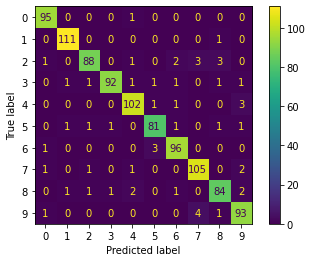

In [ ]:
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
x = plot_confusion_matrix(defaultClf, X_test, y_test,values_format = 'd')
print(metrics.accuracy_score(y_test,defaultClf.predict(X_test)))
print(metrics.f1_score(y_test,defaultClf.predict(X_test),average='macro'))

# Differences with XgBoost :

Catboost introduces two critical algorithmic advances - the implementation of ordered boosting, a permutation-driven alternative to the classic algorithm, and an innovative algorithm for processing categorical features.

# Important Parameters :
- cat_features — This parameter is a must in order to leverage Catboost preprocessing of categorical features, if you encode the categorical features yourself and don’t pass the columns indices as cat_features you are missing the essence of Catboost.

- one_hot_max_size — As mentioned before, Catboost uses a one-hot encoding for all features with at most one_hot_max_size unique values. If the categorical features have a lot of unique values, don't use one hot encoding, but depending on the dataset it may be a good idea to adjust this parameter.

- Boosting type : 
By default, the boosting type is set to “Ordered” for small datasets. This prevents overfitting but it is expensive in terms of computation. Try to set the value of this parameter to “Plain” to speed up the training.

- learning_rate & n_estimators — The smaller the learning_rate, the more n_estimators needed to utilize the model. Usually, the approach is to start with a relative high learning_rate, tune other parameters and then decrease the learning_rate while increasing n_estimators.

- max_depth — Depth of the base trees, this parameter has an high impact on training time.
- subsample — Sample rate of rows, **can’t be used in a Bayesian boosting type setting.**

- colsample_bylevel, colsample_bytree, colsample_bynode— Sample rate of columns.

- l2_leaf_reg — L2 regularization coefficient
- random_strength — Every split gets a score and random_strength is adding some randomness to the score, it helps to reduce overfitting.

In [ ]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score

def hyperopt_train_test(params):
    clf = CatBoostClassifier(**params,verbose=False,task_type = 'GPU' )
    score = cross_val_score(clf, X_train, y_train,cv=4,scoring='accuracy').mean()
    print("score {:.4f} params {}".format(score, params))
    return -score

space4rf = {
    'boosting_type': hp.choice('boosting_type',['Plain','Ordered']),
    'max_depth': hp.choice('max_depth', range(3,15)),
    'learning_rate' : hp.uniform('learning_rate',0.01,0.15),
    'n_estimators': hp.choice('n_estimators',range(100,500))
}

best = fmin(hyperopt_train_test, space4rf, algo=tpe.suggest, max_evals=20)

score nan params {'boosting_type': 'Ordered', 'learning_rate': 0.07608652337423662, 'max_depth': 8, 'n_estimators': 119}
  5%|▌         | 1/20 [00:00<00:05,  3.67it/s, best loss: nan]

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
_catboost.CatBoostError: catboost/private/libs/options/catboost_options.cpp:850: On GPU loss MultiClass can't be used with ordered boosting

  FitFailedWarning)



score 0.9090 params {'boosting_type': 'Plain', 'learning_rate': 0.12176257690902662, 'max_depth': 3, 'n_estimators': 450}
score 0.9283 params {'boosting_type': 'Plain', 'learning_rate': 0.11165009042245916, 'max_depth': 9, 'n_estimators': 114}
 15%|█▌        | 3/20 [01:21<06:31, 23.02s/it, best loss: nan]

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
_catboost.CatBoostError: catboost/private/libs/options/catboost_options.cpp:850: On GPU loss MultiClass can't be used with ordered boosting

  FitFailedWarning)



score nan params {'boosting_type': 'Ordered', 'learning_rate': 0.09975917371400535, 'max_depth': 7, 'n_estimators': 129}
 20%|██        | 4/20 [01:21<04:19, 16.24s/it, best loss: nan]

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
_catboost.CatBoostError: catboost/private/libs/options/catboost_options.cpp:850: On GPU loss MultiClass can't be used with ordered boosting

  FitFailedWarning)



score nan params {'boosting_type': 'Ordered', 'learning_rate': 0.09883294348718302, 'max_depth': 6, 'n_estimators': 233}
score 0.9405 params {'boosting_type': 'Plain', 'learning_rate': 0.14597052138114325, 'max_depth': 10, 'n_estimators': 403}
score 0.9030 params {'boosting_type': 'Plain', 'learning_rate': 0.039370855587348576, 'max_depth': 5, 'n_estimators': 139}
score 0.9060 params {'boosting_type': 'Plain', 'learning_rate': 0.1448925746359182, 'max_depth': 3, 'n_estimators': 338}
score 0.9183 params {'boosting_type': 'Plain', 'learning_rate': 0.035498526822780825, 'max_depth': 6, 'n_estimators': 216}
 45%|████▌     | 9/20 [07:51<09:06, 49.67s/it, best loss: nan]

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
_catboost.CatBoostError: catboost/private/libs/options/catboost_options.cpp:850: On GPU loss MultiClass can't be used with ordered boosting

  FitFailedWarning)



score nan params {'boosting_type': 'Ordered', 'learning_rate': 0.021362119085425547, 'max_depth': 6, 'n_estimators': 313}
score 0.9240 params {'boosting_type': 'Plain', 'learning_rate': 0.03463589211701426, 'max_depth': 11, 'n_estimators': 259}
score 0.9305 params {'boosting_type': 'Plain', 'learning_rate': 0.08509316219799193, 'max_depth': 9, 'n_estimators': 188}
score 0.9365 params {'boosting_type': 'Plain', 'learning_rate': 0.08766346315402461, 'max_depth': 11, 'n_estimators': 347}
                                                                

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
_catboost.CatBoostError: catboost/private/libs/options/catboost_options.cpp:850: On GPU loss MultiClass can't be used with ordered boosting

  FitFailedWarning)



score nan params {'boosting_type': 'Ordered', 'learning_rate': 0.052471156620546085, 'max_depth': 9, 'n_estimators': 116}
score 0.9342 params {'boosting_type': 'Plain', 'learning_rate': 0.09834143034185241, 'max_depth': 9, 'n_estimators': 285}
 75%|███████▌  | 15/20 [31:29<15:55, 191.11s/it, best loss: nan]

In [ ]:
from catboost import CatBoostClassifier
bestClf =  CatBoostClassifier(learning_rate = 0.1459705, max_depth = 10, n_estimators = 400, boosting_type = 'Plain',task_type = 'GPU')
bestClf.fit(X_train, y_train)

0.957
0.956314494820643


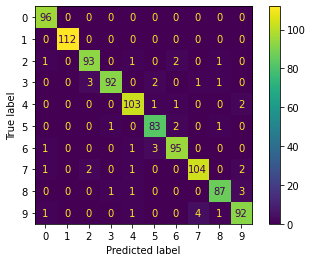

In [ ]:
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
_ = plot_confusion_matrix(bestClf, X_test, y_test,values_format = 'd')
print(metrics.accuracy_score(y_test,bestClf.predict(X_test)))
print(metrics.f1_score(y_test,bestClf.predict(X_test),average='macro'))

# Overfitting detector : 
- https://catboost.ai/docs/features/overfitting-detector-desc.html
- https://stackoverflow.com/questions/45533159/how-to-work-with-the-catboost-overfitting-detector

In [ ]:
from catboost import CatBoostClassifier, Pool
eval_pool = Pool(X_test, y_test)
model = CatBoostClassifier(learning_rate = 0.1459705, max_depth = 10, n_estimators = 400,
                          boosting_type = 'Plain', task_type = 'GPU', eval_metric = 'Accuracy' )
model.fit(X_train, y_train, eval_set=eval_pool, early_stopping_rounds=12)

0:	learn: 0.7997500	test: 0.6760000	best: 0.6760000 (0)	total: 484ms	remaining: 3m 13s
1:	learn: 0.8565000	test: 0.7500000	best: 0.7500000 (1)	total: 822ms	remaining: 2m 43s
2:	learn: 0.8727500	test: 0.7860000	best: 0.7860000 (2)	total: 1.16s	remaining: 2m 34s
3:	learn: 0.8882500	test: 0.8150000	best: 0.8150000 (3)	total: 1.5s	remaining: 2m 28s
4:	learn: 0.9040000	test: 0.8220000	best: 0.8220000 (4)	total: 1.83s	remaining: 2m 24s
5:	learn: 0.9147500	test: 0.8430000	best: 0.8430000 (5)	total: 2.17s	remaining: 2m 22s
6:	learn: 0.9237500	test: 0.8550000	best: 0.8550000 (6)	total: 2.51s	remaining: 2m 20s
7:	learn: 0.9300000	test: 0.8680000	best: 0.8680000 (7)	total: 2.83s	remaining: 2m 18s
8:	learn: 0.9352500	test: 0.8670000	best: 0.8680000 (7)	total: 3.15s	remaining: 2m 16s
9:	learn: 0.9410000	test: 0.8720000	best: 0.8720000 (9)	total: 3.45s	remaining: 2m 14s
10:	learn: 0.9470000	test: 0.8770000	best: 0.8770000 (10)	total: 3.78s	remaining: 2m 13s
11:	learn: 0.9535000	test: 0.8790000	best:

0.955
0.9543330448765547


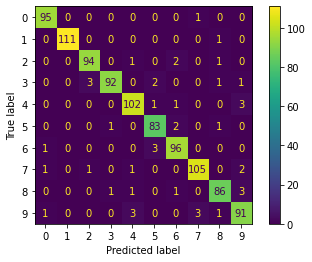

In [ ]:
_ = plot_confusion_matrix(model, X_test, y_test,values_format = 'd')
print(metrics.accuracy_score(y_test,model.predict(X_test)))
print(metrics.f1_score(y_test,model.predict(X_test),average='macro'))

# Handling categorical values :

https://medium.com/swlh/dealing-with-categorical-variables-in-machine-learning-4401b949b093

In [ ]:
import pandas as pd
df = pd.read_csv('pokemon.csv', delimiter = ',')

In [ ]:
df.head(5)

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [ ]:
df['Legendary'] = df['Legendary'].astype('int')  # when column to be predicted is in bool, catboost gives predicted column as str

In [ ]:
y = df['Legendary']
x = df.drop(['#', 'Name','Legendary'], axis = 1) 

In [ ]:
print(x.dtypes)
print(y.dtypes)

Type 1        object
Type 2        object
Total          int64
HP             int64
Attack         int64
Defense        int64
Sp. Atk        int64
Sp. Def        int64
Speed          int64
Generation     int64
dtype: object
int64


In [ ]:
from sklearn.model_selection import train_test_split
x["Type 2"] = x["Type 2"].astype('str')  # for catboost categories column , type has to be int or str. Else nan values wont be imputed.
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=101, stratify=y)

In [ ]:
X_train.head(5)

,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
247,Dark,Fire,500,75,90,50,110,80,95,2
309,Grass,nan,295,60,40,60,40,60,35,3
446,Bug,nan,194,37,25,41,25,41,25,4
69,Psychic,nan,400,40,35,30,120,70,105,1
195,Electric,nan,510,90,75,85,115,90,55,2


In [ ]:
from catboost import CatBoostClassifier
model_with_cat =  CatBoostClassifier( verbose=False, cat_features=[0,1])
model_with_cat.fit(X_train, y_train )


In [ ]:
c = model_with_cat.predict(X_test) 

0.95625
0.8672828534186515


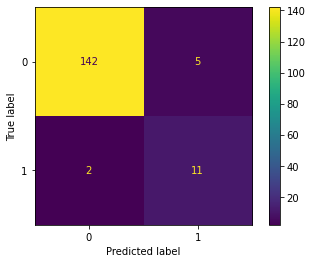

In [ ]:
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
_ = plot_confusion_matrix(model_with_cat, X_test, y_test,values_format = 'd')
print(metrics.accuracy_score(y_test,c))
print(metrics.f1_score(y_test,model_with_cat.predict(X_test),average='macro'))

In [ ]:
x1 = pd.concat([pd.get_dummies(x[['Type 1', 'Type 2']]),x.drop(['Type 1', 'Type 2'], axis = 1)], axis =1) 

In [ ]:
x1.head(5)

,Type 1_Bug,Type 1_Dark,Type 1_Dragon,Type 1_Electric,Type 1_Fairy,Type 1_Fighting,Type 1_Fire,Type 1_Flying,Type 1_Ghost,Type 1_Grass,Type 1_Ground,Type 1_Ice,Type 1_Normal,Type 1_Poison,Type 1_Psychic,Type 1_Rock,Type 1_Steel,Type 1_Water,Type 2_Bug,Type 2_Dark,Type 2_Dragon,Type 2_Electric,Type 2_Fairy,Type 2_Fighting,Type 2_Fire,Type 2_Flying,Type 2_Ghost,Type 2_Grass,Type 2_Ground,Type 2_Ice,Type 2_Normal,Type 2_Poison,Type 2_Psychic,Type 2_Rock,Type 2_Steel,Type 2_Water,Type 2_nan,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,318,45,49,49,65,65,45,1
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,405,60,62,63,80,80,60,1
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,525,80,82,83,100,100,80,1
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,625,80,100,123,122,120,80,1
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,309,39,52,43,60,50,65,1


In [ ]:
X1_train, X1_test, y1_train, y1_test = train_test_split(x1, y, test_size=0.2, random_state=101, stratify=y)
model_without_cat =  CatBoostClassifier( verbose=False)
model_without_cat.fit(X1_train, y1_train )

0.95625
0.8584249778789028


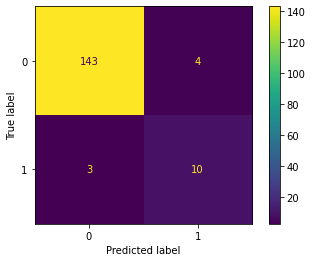

In [ ]:
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
_ = plot_confusion_matrix(model_without_cat, X1_test, y1_test,values_format = 'd')
print(metrics.accuracy_score(y1_test,model_without_cat.predict(X1_test)))
print(metrics.f1_score(y1_test,model_without_cat.predict(X1_test),average='macro'))

## While lightGBM performed worse when one-hot-encoding wasn't done, CatBoost performed much better.

In [ ]:
import catboost
pool = catboost.Pool(X_train, y_train, cat_features=[0,1])
feature_importance = model_with_cat.get_feature_importance(pool, fstr_type=catboost.EFstrType.FeatureImportance, prettified=True)
interactions = model_with_cat.get_feature_importance(pool, fstr_type=catboost.EFstrType.Interaction, prettified=True)
shap_values = model_with_cat.get_feature_importance(pool, fstr_type=catboost.EFstrType.ShapValues)

In [ ]:
print(feature_importance)
print(type(feature_importance))

   Feature Id  Importances
0       Total    45.388538
1      Type 1     8.072437
2      Type 2     7.365963
3       Speed     6.956232
4     Sp. Atk     6.678084
5      Attack     5.553245
6          HP     5.442170
7     Sp. Def     5.433031
8  Generation     4.876598
9     Defense     4.233702
<class 'pandas.core.frame.DataFrame'>


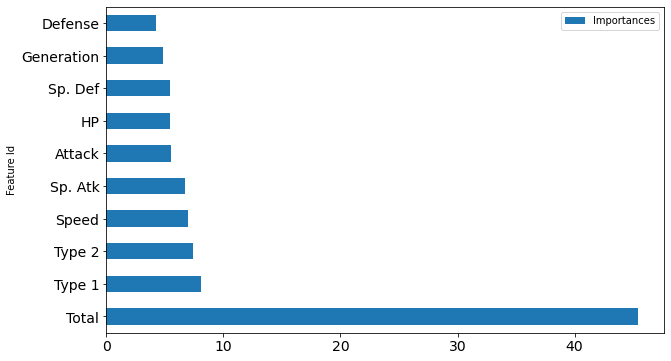

In [ ]:
feature_importance.set_index('Feature Id').plot(kind='barh', figsize=(10, 6), fontsize=14)

In [ ]:
print(interactions)

    First Feature Index  Second Feature Index  Interaction
0                     0                     2    12.733617
1                     1                     2     8.297271
2                     0                     1     6.805171
3                     2                     4     5.203435
4                     2                     7     4.942534
5                     2                     6     4.490517
6                     2                     5     4.365169
7                     2                     9     4.186573
8                     2                     8     3.336640
9                     2                     3     2.940361
10                    4                     6     2.626547
11                    0                     6     2.557565
12                    0                     8     2.333900
13                    0                     7     2.028810
14                    1                     6     1.834639
15                    0                     3     1.8112

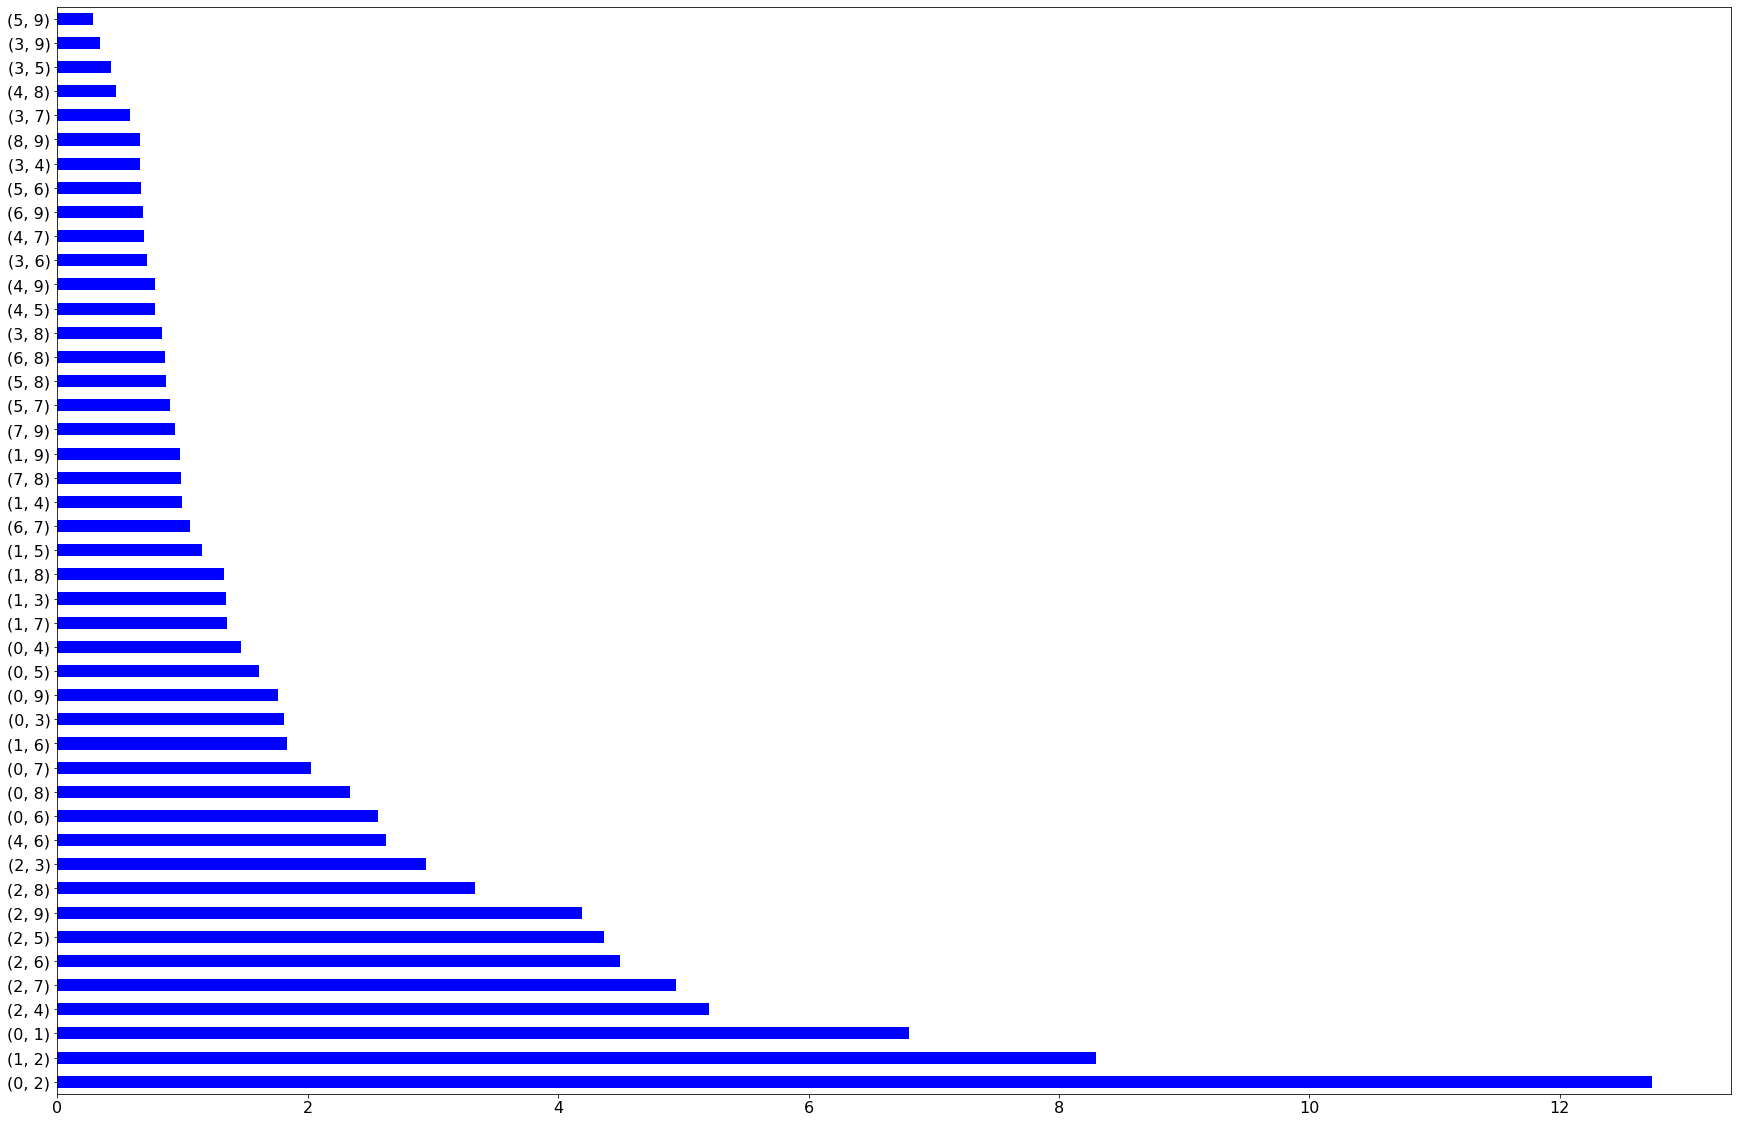

In [ ]:
pd.Series(index=zip(interactions['First Feature Index'], interactions['Second Feature Index']),
          data=interactions['Interaction'].values, name='interaction_strength')\
          .plot(kind='barh', figsize=(30, 20), fontsize=16, color='b')

In [ ]:
print(shap_values)

[[-0.2035371   0.1791968  -0.89610133 ...  0.43931679  0.03670933
  -6.48057219]
 [-0.34052066 -0.10071915 -0.83572422 ... -0.27285767 -0.17373019
  -6.48057219]
 [-0.32470053 -0.10320433 -0.79741852 ... -0.23739126 -0.08482097
  -6.48057219]
 ...
 [-0.98990607 -0.44064252  4.14917825 ...  0.38772787 -0.03096664
  -6.48057219]
 [-0.32824377 -0.10679951 -0.92032728 ... -0.23894658  0.02135682
  -6.48057219]
 [-0.26200802 -0.10305164 -0.89189667 ...  0.5149061   0.06384493
  -6.48057219]]


In [ ]:
!pip install shap

     |████████████████████████████████| 276kB 9.2MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394119 sha256=2ff2e7445146d238f1c3fab82f9f327d46ac83560693c757235ace14b49e0cf2
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


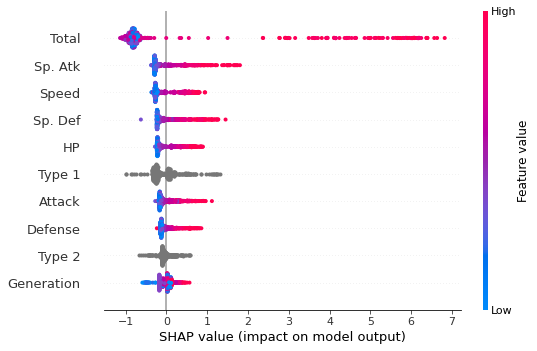

In [ ]:
import shap
shap.initjs()
shap.summary_plot(shap_values[:, :-1], X_train, feature_names=X_train.columns.tolist())

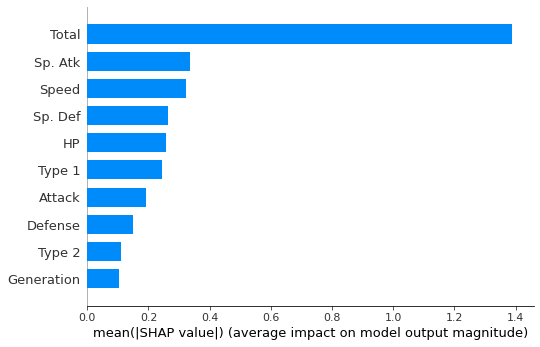

In [ ]:
shap.summary_plot(shap_values[:, :-1], X_train, feature_names=X_train.columns.tolist(), plot_type="bar")

# Observations :
- Catboost uses type 2 , which was ignore by lightGBM
- catboost can relay the interaction ans well as shap value besides feature importance.

For more :https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d